<a href="https://colab.research.google.com/github/egyvedriyanto78/Deep-Learning/blob/UAS_Kapsel_DeepL/Butterfly_ResNet18_by_EgyVedriyanto_2117051035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eksperimen Model ResNet18 untuk klasifikasi Kupu-kupu yang terdiri dari 8 kelas
Egy Vedriyanto 2117051035

## Library

In [ ]:
# Mengimpor library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Mengecek apakah GPU tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset

In [ ]:
# Mengimpor Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset kupu-kupu di Google Drive
dataset_path = '/content/drive/My Drive/DeepL/butterfly/butterfly_dataset'

# Periksa isi folder untuk memastikan dataset terakses
import os
print("Isi folder:", os.listdir(dataset_path))

Mounted at /content/drive
Isi folder: ['kupu_jojo', 'kupu_raja_limau', 'kupu_hijau_biru', 'kupu_raja_helena', 'kupu_pantat_merah', 'kupu_jarak', 'kupu_harimau_kuning_hijau', 'kupu_batik_cap']


In [ ]:
# Transformasi untuk train (augmentasi) dan test/validasi (tanpa augmentasi)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_no_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset_path ='/content/drive/My Drive/DeepL/butterfly/butterfly_dataset'  # Ganti dengan path dataset
dataset = datasets.ImageFolder(root=dataset_path)

# Membagi dataset menjadi train, validation, dan test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Terapkan transformasi ke subset dataset
train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
val_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_no_augment)
test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_no_augment)

# DataLoader untuk batch training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset berhasil dimuat. Train: {train_size}, Val: {val_size}, Test: {test_size}")

Dataset berhasil dimuat. Train: 556, Val: 159, Test: 80


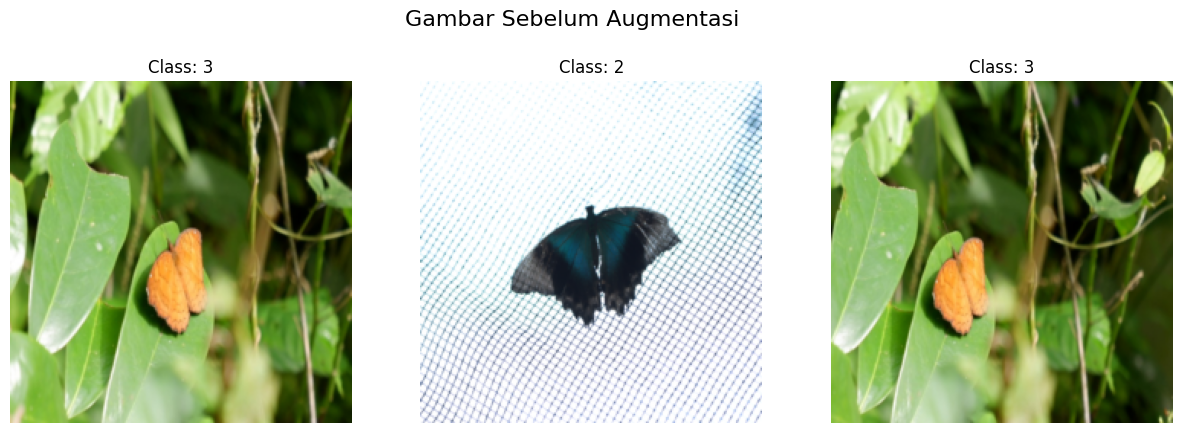

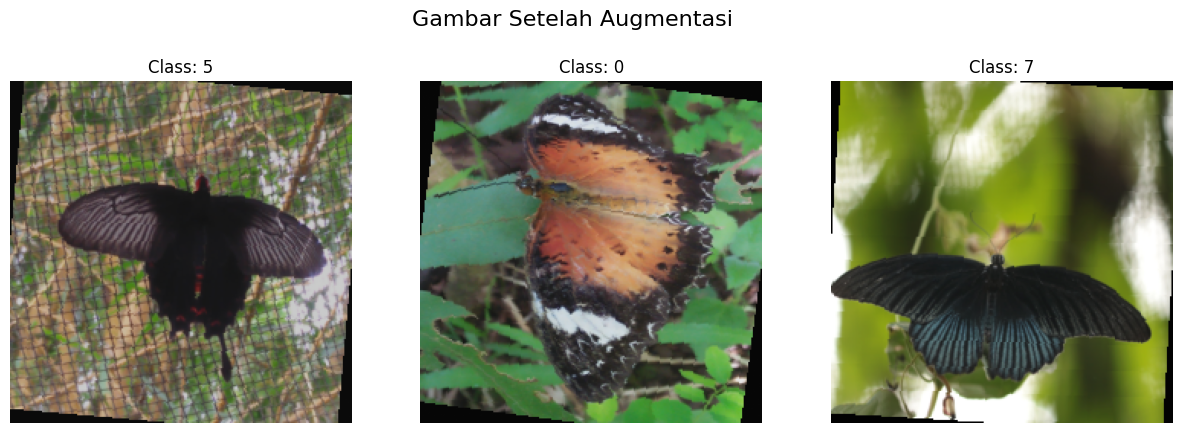

In [ ]:
import random

# Fungsi untuk menampilkan gambar
def show_images(dataset, title, num_images=3):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(num_images):
        # Pilih gambar acak dari dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]

        # Denormalisasi gambar
        img = img * 0.5 + 0.5  # Balikkan normalisasi ke rentang [0, 1]
        img = img.permute(1, 2, 0).numpy()  # Ubah tensor menjadi numpy array

        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"Class: {label}")
    plt.show()

# Menampilkan 3 gambar acak dari dataset sebelum augmentasi (transform_no_augment)
show_images(val_dataset.dataset, "Gambar Sebelum Augmentasi")

# Menampilkan 3 gambar acak dari dataset setelah augmentasi (transform_train)
show_images(train_dataset.dataset, "Gambar Setelah Augmentasi")

## Modeling

In [ ]:
# Load ResNet18 dari torchvision dengan penyesuaian output
resnet18 = models.resnet18(pretrained=True)  # Pretrained weights pada ImageNet
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(dataset.classes))  # Penyesuaian output sesuai jumlah kelas
resnet18 = resnet18.to(device)

print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Menggunakan CrossEntropyLoss untuk klasifikasi multi-kelas
criterion = nn.CrossEntropyLoss()

# Optimizer menggunakan Adam
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

## Model Training

In [ ]:
from torch.cuda.amp import autocast, GradScaler

# Inisialisasi scaler untuk menjaga stabilitas gradien
scaler = GradScaler()

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Mixed precision forward pass
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return history

<ipython-input-9-e3329cc34a1f>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Pelatihan model ResNet18
epochs = 20
history = train_model(resnet18, train_loader, val_loader, criterion, optimizer, epochs)

<ipython-input-9-e3329cc34a1f>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-9-e3329cc34a1f>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Train Loss: 0.3281, Val Loss: 15.9284
Epoch 2/20, Train Loss: 0.0963, Val Loss: 0.0404
Epoch 3/20, Train Loss: 0.1093, Val Loss: 0.2610
Epoch 4/20, Train Loss: 0.0692, Val Loss: 0.0269
Epoch 5/20, Train Loss: 0.0429, Val Loss: 0.0485
Epoch 6/20, Train Loss: 0.0899, Val Loss: 1.3817
Epoch 7/20, Train Loss: 0.0190, Val Loss: 0.0034
Epoch 8/20, Train Loss: 0.0175, Val Loss: 0.0002
Epoch 9/20, Train Loss: 0.0315, Val Loss: 0.0002
Epoch 10/20, Train Loss: 0.0131, Val Loss: 0.0077
Epoch 11/20, Train Loss: 0.0394, Val Loss: 1.4634
Epoch 12/20, Train Loss: 0.0271, Val Loss: 0.0005
Epoch 13/20, Train Loss: 0.0027, Val Loss: 0.0009
Epoch 14/20, Train Loss: 0.0016, Val Loss: 0.0001
Epoch 15/20, Train Loss: 0.0043, Val Loss: 0.0001
Epoch 16/20, Train Loss: 0.0015, Val Loss: 0.0001
Epoch 17/20, Train Loss: 0.0457, Val Loss: 0.4572
Epoch 18/20, Train Loss: 0.0518, Val Loss: 0.1937
Epoch 19/20, Train Loss: 0.0946, Val Loss: 0.1455
Epoch 20/20, Train Loss: 0.1762, Val Loss: 0.2803


## Model Evaluation

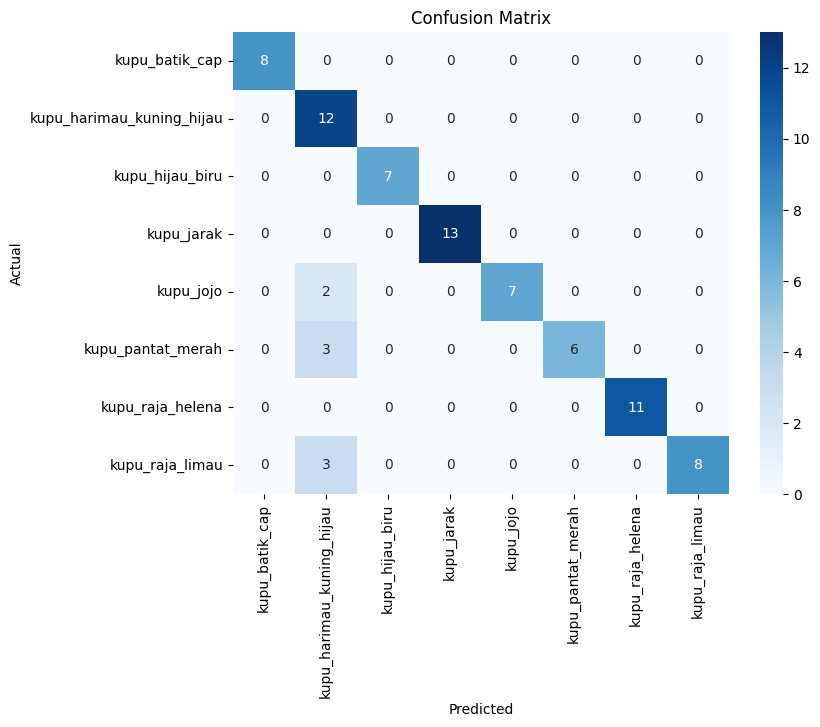

Classification Report:
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      1.00      1.00         8
kupu_harimau_kuning_hijau       0.60      1.00      0.75        12
          kupu_hijau_biru       1.00      1.00      1.00         7
               kupu_jarak       1.00      1.00      1.00        13
                kupu_jojo       1.00      0.78      0.88         9
        kupu_pantat_merah       1.00      0.67      0.80         9
         kupu_raja_helena       1.00      1.00      1.00        11
          kupu_raja_limau       1.00      0.73      0.84        11

                 accuracy                           0.90        80
                macro avg       0.95      0.90      0.91        80
             weighted avg       0.94      0.90      0.90        80



In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

y_true, y_pred = evaluate_model(resnet18, test_loader)

# Confusion matrix dan classification report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=dataset.classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(report)

## Model Prediction

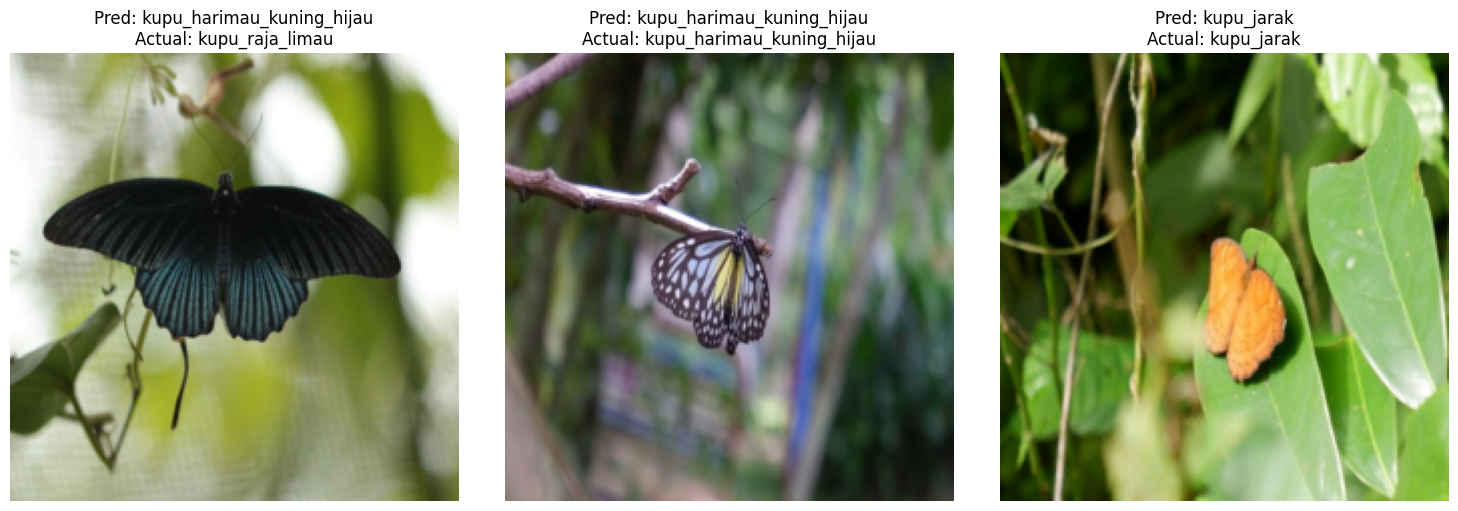

In [ ]:
def show_predictions(model, dataset, class_names, num_images=3):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {class_names[pred.item()]}\nActual: {class_names[label]}")

    plt.tight_layout()
    plt.show()

class_names = test_dataset.dataset.classes
show_predictions(resnet18, test_dataset, class_names, num_images=3)